# Assignment 2: APIs and Working with Data

This assignment covers **Chapters 5-8** from the [textbook](https://wesmckinney.com/book/) as well as lecture material from Weeks 1-3. Please complete this assignment by providing answers in cells after the question. Use **Code** cells to write and run any code you need to answer the question and **Markdown** cells to write out answers in words. After you are finished with the assignment, remember to download it as an **HTML file** and submit it in **ELMS**.

In [3]:
from requests import get
import numpy as np
import pandas as pd
import time

# API pagination

The code below uses the [Project Gutenberg API](https://gutendex.com/) to get a list of available books written by authors who were alive before the year 425 B.C. There are 109 books available, but each query will only up to 32 titles, so we'll need to send multiple requests to retrieve all the data



In [4]:
gutenberg_url = 'https://gutendex.com/books/'
guten_params = {'languages':'en', 
                'author_year_end':-425,  
                'page':5              # this is the pagination parameter, so you need to increment it to get the next page of data
               }
books = get(gutenberg_url, params = guten_params)  # this command would retrieve the first page of results



In [5]:
if books.json().get("results") is not None: print("hllo")

<div class="alert alert-block alert-success"> 
TIP: it might help to look at the results in a browser window to get a sense of how each response is structured. You can look at some example data here: 

 - [first page of data](https://gutendex.com/books/?author_year_end=-450&languages=en&page=1)

</div>

## A1
<b style="color:red;"> A1) Write a `while` loop that will retrieve a list of all 109 books and then create a Pandas Data Frame object with the title and summary of each book.</a>

(Be sure to include a small rest between each query by adding `time.sleep(.3)` inside your loop.)

Here's one method that we could use to paginate through the API results:

In [6]:
gutenberg_url = 'https://gutendex.com/books/'
page  = 1
all_results = []
morepages = True

while morepages:
    print(page, end=', ')

    guten_params = {
        'languages': 'en',
        'author_year_end': -425,
        'page': page  # Incremented dynamically
    }
    # Fetch the current page of results
    response = get(gutenberg_url, params=guten_params)
    # Convert response to JSON
    json_books = response.json()
    if json_books.get("results") is None:
        break
    # Or try: 
    # morepages = json_books.get("next") is not None
    all_results.append(json_books)  # could also add an if morepages == True: condition here to ensure you leave out pages with no data
    # increment page counter by 1 
    page+=1
    time.sleep(.3)
    

1, 2, 3, 4, 5, 

### Making the data frame

You can use a list comprehension to convert every page into a data frame and then use `pd.concat` to combine all the data frames into one.

(note that I'm using `get()` here to index the dictionary because it will avoid throwing an error message when the "results" key is missing)

In [7]:
df = pd.concat([pd.DataFrame(i.get('results')) for i in all_results], ignore_index=True)
df.head()

,id,title,authors,summaries,editors,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count
0,1497,The Republic,"[{'name': 'Plato', 'birth_year': -428, 'death_...","[""The Republic"" by Plato is a philosophical di...",[],"[{'name': 'Jowett, Benjamin', 'birth_year': 18...","[Classical literature, Justice -- Early works ...","[Category: Classics of Literature, Category: P...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,31234
1,6130,The Iliad,"[{'name': 'Homer', 'birth_year': -750, 'death_...","[""The Iliad"" by Homer is an epic poem traditio...",[],"[{'name': 'Pope, Alexander', 'birth_year': 168...","[Achilles (Mythological character) -- Poetry, ...","[Category: Classics of Literature, Category: M...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,29161
2,1727,The Odyssey: Rendered into English prose for t...,"[{'name': 'Homer', 'birth_year': -750, 'death_...","[""The Odyssey"" by Homer is an epic poem attrib...",[],"[{'name': 'Butler, Samuel', 'birth_year': 1835...","[Epic poetry, Greek -- Translations into Engli...","[Category: Classics of Literature, Category: M...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,21916
3,7142,The History of the Peloponnesian War,"[{'name': 'Thucydides', 'birth_year': -460, 'd...","[""The History of the Peloponnesian War"" by Thu...",[],"[{'name': 'Crawley, Richard', 'birth_year': 18...","[Greece -- History -- Peloponnesian War, 431-4...","[Category: History - Ancient, Category: Histor...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,16521
4,1600,Symposium,"[{'name': 'Plato', 'birth_year': -428, 'death_...","[""Symposium"" by Plato is a philosophical dialo...",[],"[{'name': 'Jowett, Benjamin', 'birth_year': 18...","[Classical literature, Love -- Early works to ...","[Category: Classics of Literature, Category: P...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,15884



Alternatively, you can use a loop or a nested comprehension to extract each element you want to use and put it into a list of data frames:

In [8]:
processed_results = []
for page in all_results:
    for i in page.get('results', []):
        book = {'title' :i.get('title'), 'summaries' : i.get('summaries')}
        processed_results.append(book)
title_and_summary = pd.DataFrame(processed_results)


You might want to unnest the nested "summaries" column so that it just contains strings rather than a list. One way to do this is using `DataFrame.explode()`, which will expand nested cells and create a long format data frame:

In [9]:
title_and_summary.explode('summaries').head()

,title,summaries
0,The Republic,"""The Republic"" by Plato is a philosophical dia..."
1,The Iliad,"""The Iliad"" by Homer is an epic poem tradition..."
2,The Odyssey: Rendered into English prose for t...,"""The Odyssey"" by Homer is an epic poem attribu..."
3,The History of the Peloponnesian War,"""The History of the Peloponnesian War"" by Thuc..."
4,Symposium,"""Symposium"" by Plato is a philosophical dialog..."


## A2
<b style="color:red;"> A2) Bonus (not a required question!) what was the median age of death of the author(s) of each book in your results?</a>


### Method 1

You can retrieve this using a nested loop or list comprehension over values of `all_results`. We need the nested looping here because some books have more than one author. We also need a check to see if both `death_year` and `birth_year` are present in the result, since this information appears to be missing for some books. Once you have everything in a list of dictionaries, you can convert to a `DataFrame` and then use `describe` to get the median.



In [10]:
author_dates = []
# loop through all pages of results
for i in all_results:
    result_i = i.get('results')
    # loop through each book
    for j in result_i:
        authors = j.get('authors')
        # loop through each author
        for a in authors:
            death = a.get('death_year')
            birth = a.get('birth_year')
            name = a.get('name')
            # check to make sure there's a death and a birth year before calculating the age
            if death is not None and birth is not None:
                age = death - birth
            else:
                age = None
            # append the results to the list
            author_dates.append(
                {'name' : name ,
                'death_year': death,
                'birth_year': birth,
                'age' : age

            } )

# make a data frame and then use describe to get the median:
pd.DataFrame(author_dates).describe()

,death_year,birth_year,age
count,123.000000,120.000000,120.000000
mean,-227.869919,-340.875000,78.783333
std,667.279342,618.224396,13.459671
min,-650.000000,-750.000000,29.000000
25%,-456.000000,-525.000000,72.000000
50%,-380.000000,-442.500000,80.000000
75%,-348.000000,-428.000000,83.000000
max,1924.000000,1875.000000,100.000000


### Method 2

You could also do this using mostly functions from Pandas. `explode` will unnest a list-column into multiple rows, and `json_normalize` will turn dictionary columns into separate columns for each key-value pair. Then you'll just need to use `describe` on the result:

In [11]:

df = pd.concat([pd.DataFrame(i.get('results')) for i in all_results], ignore_index=True)
df= df.explode("authors")
author_info = pd.json_normalize(df['authors'])

author_info['difference'] = author_info['death_year'] - author_info['birth_year']
author_info.describe()


,birth_year,death_year,difference
count,120.000000,123.000000,120.000000
mean,-340.875000,-227.869919,78.783333
std,618.224396,667.279342,13.459671
min,-750.000000,-650.000000,29.000000
25%,-525.000000,-456.000000,72.000000
50%,-442.500000,-380.000000,80.000000
75%,-428.000000,-348.000000,83.000000
max,1875.000000,1924.000000,100.000000


# Census API

From the Census API, get the mean family income for each county in the US, as well as the percent of people within those counties that identify as only White, only Black or African American, only Asian, only American Indian and Alaska Native, and Hispanic or Latino. These variables are:

- `NAME`: Name of the county
- `DP03_0087E`: Mean income
- `DP05_0037PE`: Percent of people who identify only as White
- `DP05_0038PE`: Percent of people who identify only as Black or African American
- `DP05_0039PE`: Percent of people who identify only as American Indian or Alaska Native
- `DP05_0044PE`: Percent of people who identify only as Asian
- `DP05_0072PE`: Percent of people who identify as Hispanic or Latino

Make a Data Frame that contains all of this information, with each row representing a county and each column representing the above variables as well as the state and county codes (the API should provide these for you without needing to ask for it). Name the columns something more descriptive (for example, `mean_income` instead of `DP03_0087E`). Make sure that the values are numeric rather than strings (the Census API should return them as strings). Remove any rows that contain values below 0 for any variable.

Using this dataset, answer the following questions. 
1) Describe the mean income variable. What is the county with the highest mean income? The lowest?
2) Does there seem to be a relationship between the mean income of a county and the percentage of people who identify as White? Look at a scatterplot to answer this question. Repeat this comparison with mean income for each of the other Race/Ethnicity variables. 
    > To make a scatterplot, you can use the `plot.scatter` method and put the names of the two columns you want to graph as the arguments. For example, you would use df.plot.scatter('x','y') if 'x' and 'y' are the column names of what you want to graph in df.
3) Maryland is state code 24. For the counties in Maryland, is the relationship the same as or different from counties in the US as a whole?




In [12]:
census_base_url = 'https://api.census.gov/data/2020/acs/acs5/profile'


census_params = {'get':'NAME,DP03_0087E,DP05_0037PE,DP05_0038PE,DP05_0039PE,DP05_0044PE,DP05_0072PE',
                 'for':'county:*'}

r = get(census_base_url, params = census_params)
r.status_code


200

In [13]:
colnames = ['county', 'mean_income', 'pct_white', 'pct_black','pct_amerind','pct_asian','pct_hisp','state_code', 'county_code']
census_data = pd.DataFrame(r.json()[1:], columns=colnames)

# converting to numeric: 
census_data[colnames[1:]] = census_data[colnames[1:]].apply(func=lambda x: pd.to_numeric(x))



In [14]:
# checking numeric descriptions
census_data.describe()

,mean_income,pct_white,pct_black,pct_amerind,pct_asian,pct_hisp,state_code,county_code
count,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000
mean,83989.573735,81.195654,9.085688,1.912884,1.385191,6.821267,31.281590,102.849115
std,22303.218193,17.346831,14.498975,7.637889,2.831043,12.228205,16.282861,106.645178
min,19989.000000,3.300000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,71228.000000,73.600000,0.700000,0.100000,0.300000,1.100000,19.000000,35.000000
50%,81018.000000,87.700000,2.400000,0.300000,0.600000,2.500000,30.000000,79.000000
75%,93246.000000,94.000000,10.200000,0.800000,1.300000,6.100000,46.000000,133.000000
max,223262.000000,100.000000,87.800000,94.500000,42.600000,96.700000,72.000000,840.000000


## B1
<b style="color:red;"> B1) Describe the mean income variable. What is the county with the highest mean income? The lowest? </b>

The highest income county is Marin County, CA. The lowest is Maricao Municipio, Puerto Rico. 


### Method 1

Use `idxmax()`, and `idxmin()` to get the index of the lowest and highest values, then pass those to `.iloc` 


In [15]:
# method 1 
highest_county = census_data.mean_income.idxmax()

lowest_county = census_data.mean_income.idxmin()

census_data.iloc[[lowest_county, highest_county]]

,county,mean_income,pct_white,pct_black,pct_amerind,pct_asian,pct_hisp,state_code,county_code
1169,"Maricao Municipio, Puerto Rico",19989,49.8,1.6,0.4,0.0,0.0,72,93
240,"Marin County, California",223262,76.7,2.3,0.3,5.8,7.0,6,41


### Method 2 

Sort by `mean_income` and then use `iloc` with negative indexing to get  the first and last row:

In [16]:
 
census_data.sort_values("mean_income").iloc[[0,-1]]

,county,mean_income,pct_white,pct_black,pct_amerind,pct_asian,pct_hisp,state_code,county_code
1169,"Maricao Municipio, Puerto Rico",19989,49.8,1.6,0.4,0.0,0.0,72,93
240,"Marin County, California",223262,76.7,2.3,0.3,5.8,7.0,6,41


## B2
<b style="color:red;">B2) Does there seem to be a relationship between the mean income of a county and the percentage of people who identify as White? Look at a scatterplot to answer this question. Repeat this comparison with mean income for each of the other Race/Ethnicity variables. </b>

> To make a scatterplot, you can use the `plot.scatter` method and put the names of the two columns you want to graph as the arguments. For example, you would use df.plot.scatter('x','y') if 'x' and 'y' are the column names of what you want to graph in df.

### Method 1
We can use `plot.scatter` and just write a separate line of code for each group. 



<Axes: xlabel='pct_hisp', ylabel='mean_income'>

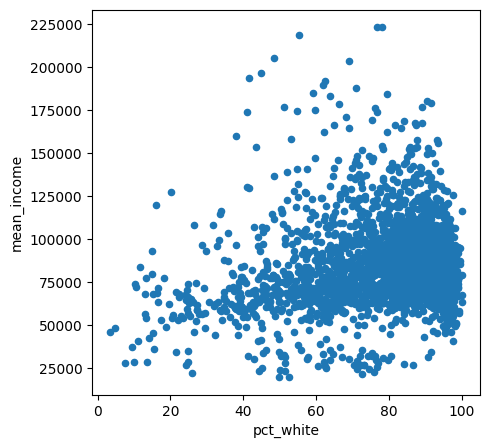

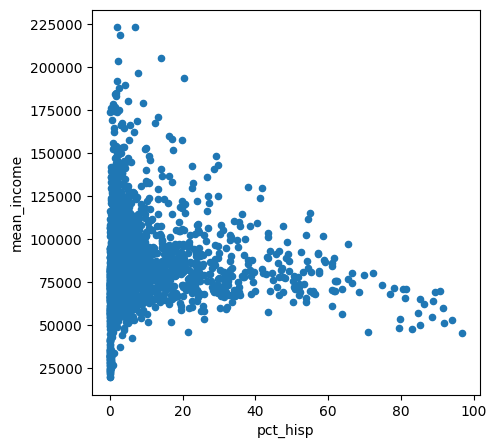

In [17]:

census_data.plot.scatter(x='pct_white', y='mean_income', figsize=(5,5)) 
census_data.plot.scatter(x='pct_hisp', y='mean_income', figsize=(5,5))
# and so on ...

### Method 2

This is really the same basic idea, but using a loop and `matplotlib` to control the placement of the plots



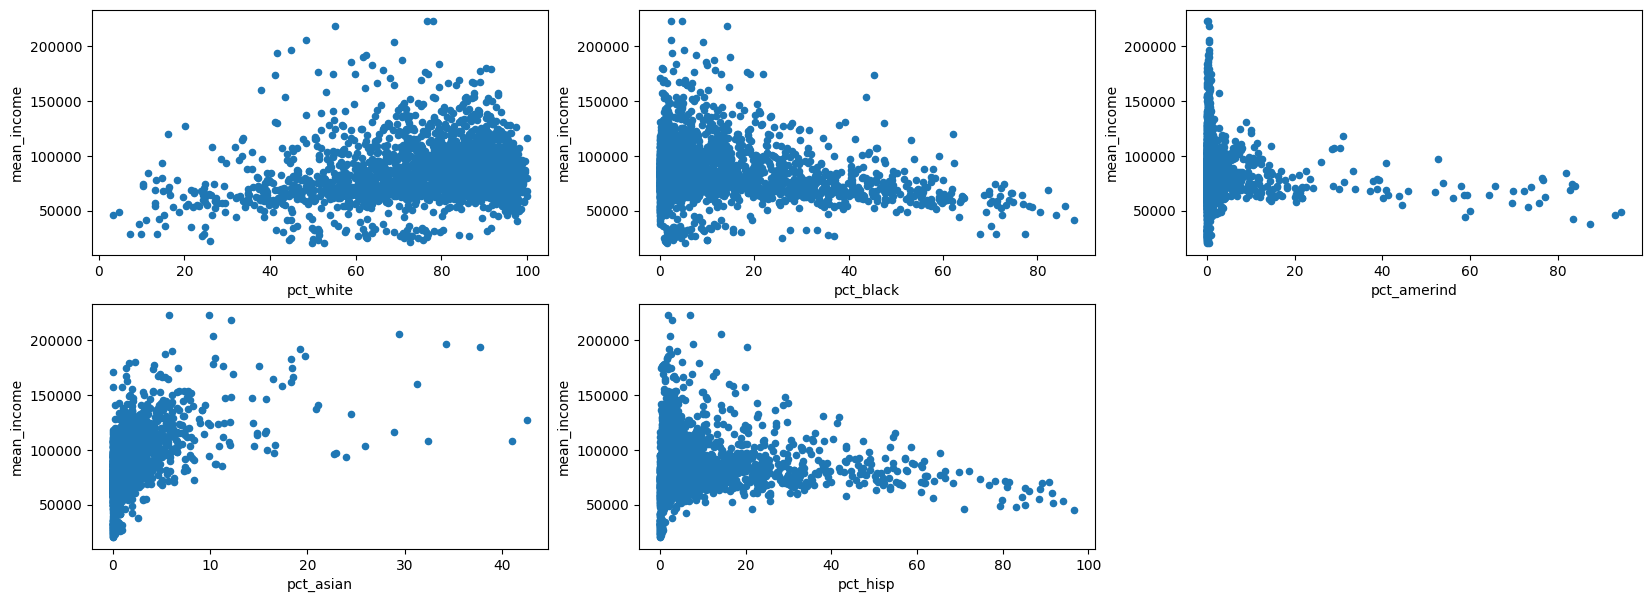

In [18]:
import matplotlib.pyplot as plt
cols = ['pct_white', 'pct_black', 'pct_amerind', 'pct_asian', 'pct_hisp']
ncols = 3
nrows = 2
index = 0 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes[-1, -1].axis('off')
for i in cols:
    census_data.columns.get_loc(i)
    row    = int(index / ncols)
    column = index % ncols
    census_data.plot.scatter(x=i, y='mean_income', figsize=(20,7), ax=axes[row,column]) 
    index = index + 1

    
    
    

### Method 3

If we first use `melt` on our data to get it into long format, we can create a faceted plot using the seaborn package.

In [25]:
import seaborn as sns

# melting the data. Everything except the id_vars goes to long format: 
census_longer = census_data.melt(id_vars = ['county','state_code', 'county_code', 'mean_income'])
# sort by county name so you can see how this has changed: 
census_longer.sort_values('county').head(n=5)


,county,state_code,county_code,mean_income,variable,value
12458,"Abbeville County, South Carolina",45,1,69592,pct_asian,0.6
6016,"Abbeville County, South Carolina",45,1,69592,pct_black,27.2
9237,"Abbeville County, South Carolina",45,1,69592,pct_amerind,0.4
15679,"Abbeville County, South Carolina",45,1,69592,pct_hisp,0.4
2795,"Abbeville County, South Carolina",45,1,69592,pct_white,69.6


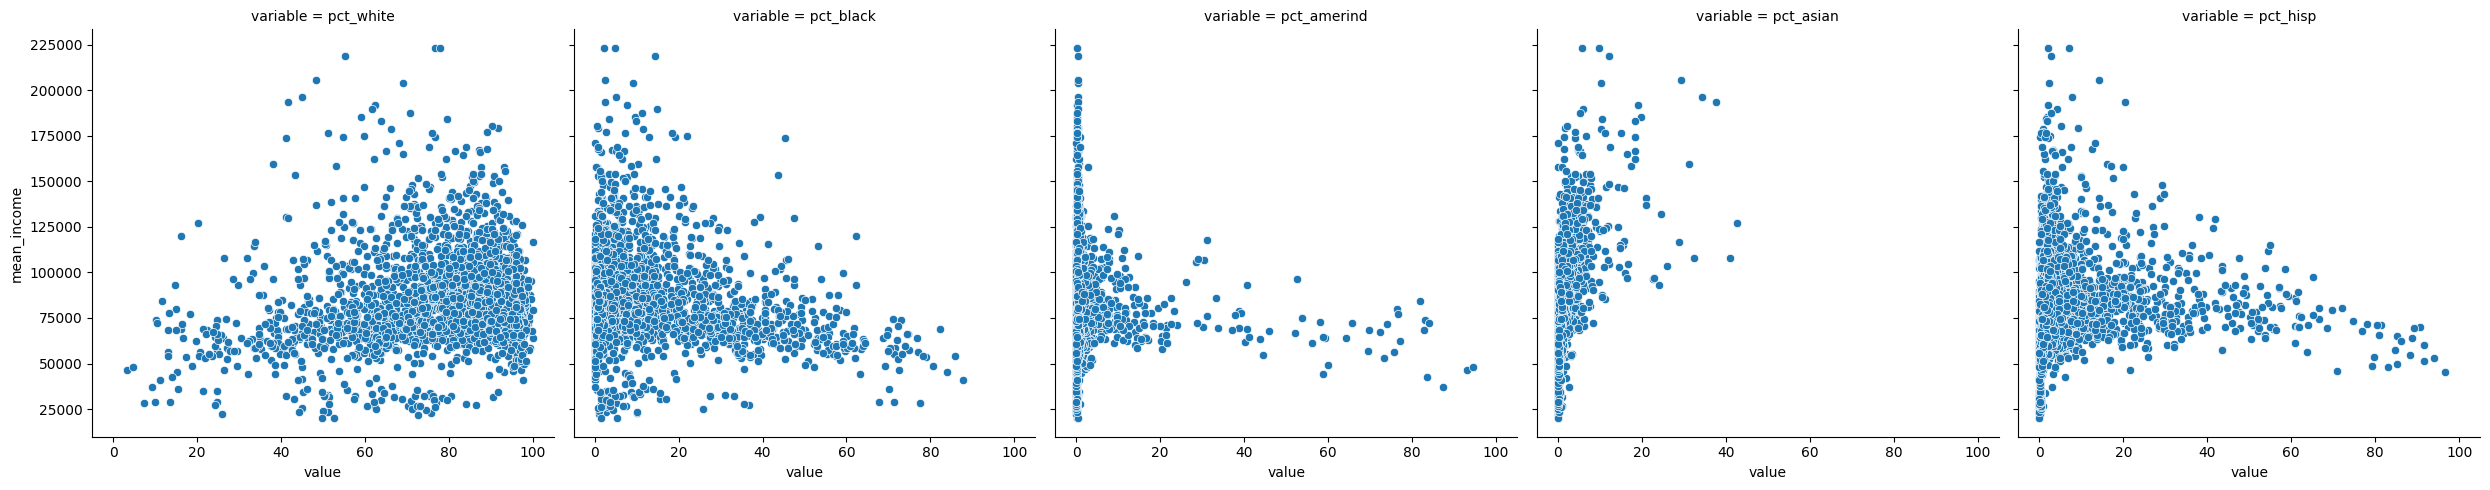

In [26]:
g = sns.relplot(kind='scatter', data=census_longer, x='value', y='mean_income', col='variable')


## B3

<b style="color:red;">B3) Maryland is state code 24. For the counties in Maryland, is the relationship the same as or different from counties in the US as a whole? Support your argument with summary statistics or a visualization</b>




Answer: The relationship is less apparent (or maybe even reversed) when we subset the data to include Maryland only.

### Method 1

<Axes: xlabel='pct_white', ylabel='mean_income'>

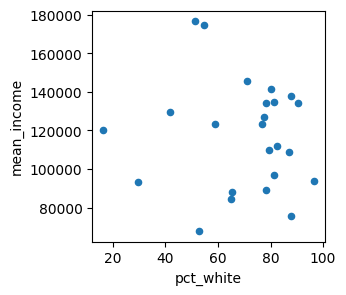

In [27]:
md_data = census_data.loc[census_data['state_code'] == 24]
md_data.plot.scatter(x='pct_white', y='mean_income', figsize=(3,3)) 

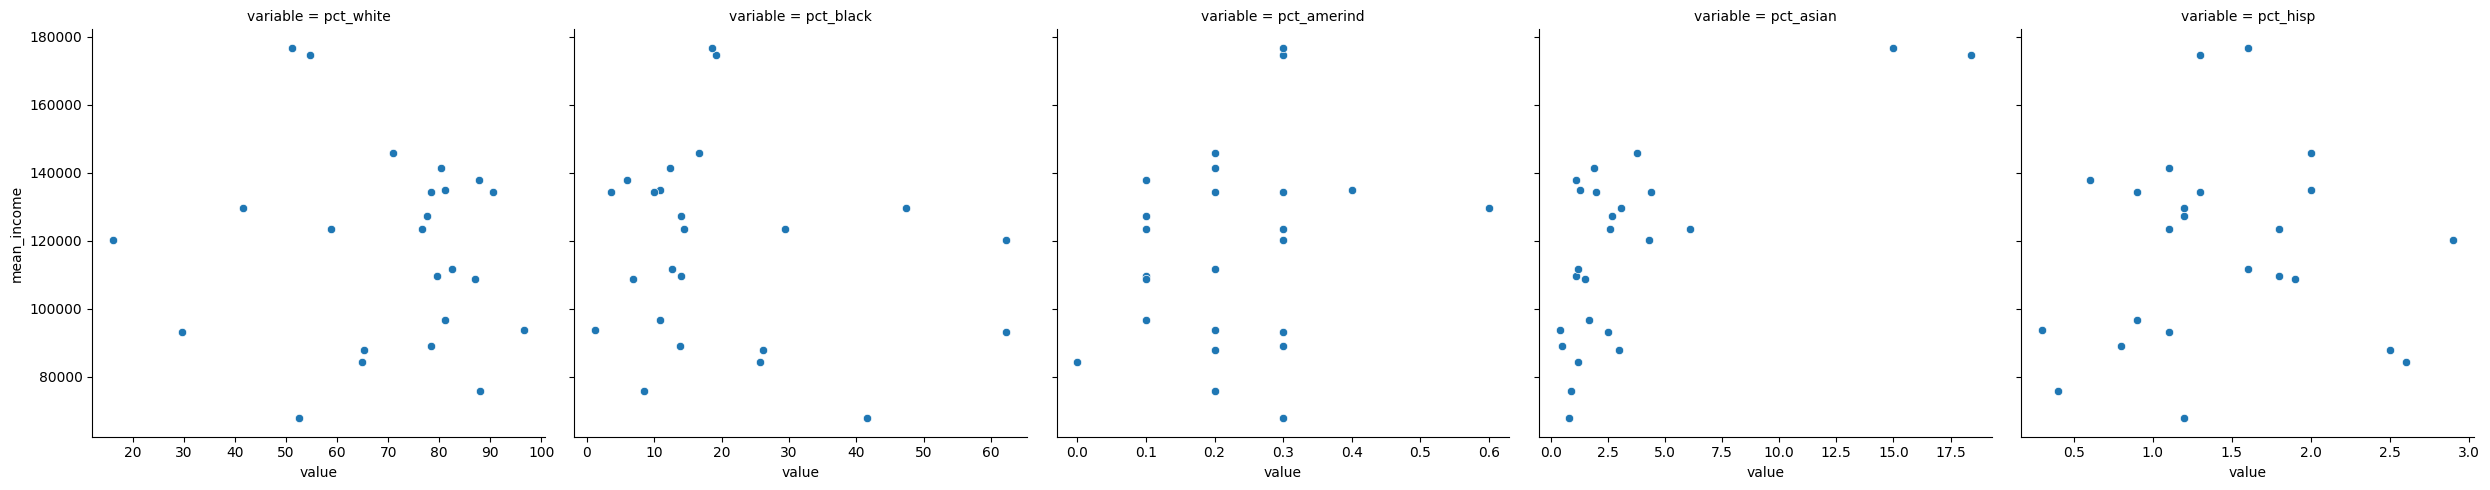

In [28]:
md_longer = census_longer.loc[census_longer['state_code'] == 24]

sns.relplot(kind='scatter', data=md_longer, x='value', y='mean_income', col='variable', 
            facet_kws={'sharey': True, 'sharex': False} # turn off x axis sharing so each plot has its own range
           )



### Method 2


If the relationship is unclear, you can look at correlations between matrix items instead and then compare/contrast. A correlation coefficient ranges between -1 to +1. Negative values indicate negative relationships, positive values indicate positive relationships, and values closer to 0 indicate no relationship. 

In [29]:
number_cols = ['mean_income', 'pct_white', 'pct_black','pct_asian','pct_hisp','pct_amerind' ]

census_data[number_cols].corr()['mean_income']


mean_income    1.000000
pct_white      0.126323
pct_black     -0.159583
pct_asian      0.503761
pct_hisp      -0.008055
pct_amerind   -0.095403
Name: mean_income, dtype: float64

In [30]:
md_data[number_cols].corr()['mean_income']

mean_income    1.000000
pct_white     -0.083026
pct_black     -0.169308
pct_asian      0.705896
pct_hisp       0.072143
pct_amerind    0.231007
Name: mean_income, dtype: float64